## Setups, Installations and Imports

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

2.8.0


In [ ]:
!nvidia-smi

Sun May 22 14:48:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import cv2
import numpy as np
import PIL
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
seed_out = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

# Prepare Dataset

In [ ]:
def open_resize(path):
    return np.array((PIL.Image.open(path)).convert('L').resize((1024, 512)))/255

In [ ]:
data_dir = "../../IN/PNG/bases/"
base_dir = "../../IN/PNG/generated_treatments/"
bases = {}
for base in os.listdir(base_dir):
  name = base.split(".")[0]
  bases[name] = open_resize(base_dir + name + ".png")

x_data = []
y_data = []

for dir in [x[0] for x in os.walk(data_dir)]:
    for file in os.listdir(dir):
        filename = os.fsdecode(file)
        if ".png" and "_" in filename:
            x_data.append(open_resize(os.path.join(dir, filename)))
            y_data.append(bases[filename.split("_")[0]])

x_data = np.asarray(x_data, dtype=np.float32)
y_data = np.asarray(y_data, dtype=np.float32)

## Shuffling datasets and setting val set

In [ ]:
p = np.random.permutation(len(x_data))
x_data, y_data = x_data[p], y_data[p]

l = len(x_data)
training_size = int(l * 0.85)
# test_size = int(l * 0.15)
val_size = int(l * 0.15)

x_train = x_data[:training_size]
y_train = y_data[:training_size]

# x_test = x_data[training_size:training_size + test_size]
# y_test = y_data[training_size:training_size + test_size]
               
# x_val = x_data[training_size + test_size:]
# y_val = y_data[training_size + test_size:]


x_val = x_data[training_size:]
y_val = y_data[training_size:]


In [ ]:
def show(img):
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

In [ ]:
def show_full_res(img):
    cv2.imshow(img*255)

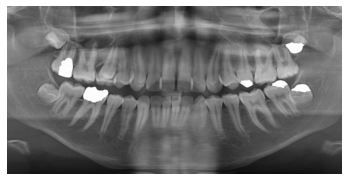

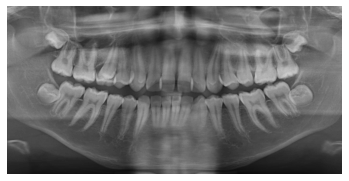

In [ ]:
show(x_train[8])
show(y_train[8])


In [ ]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(512, 1024,1)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

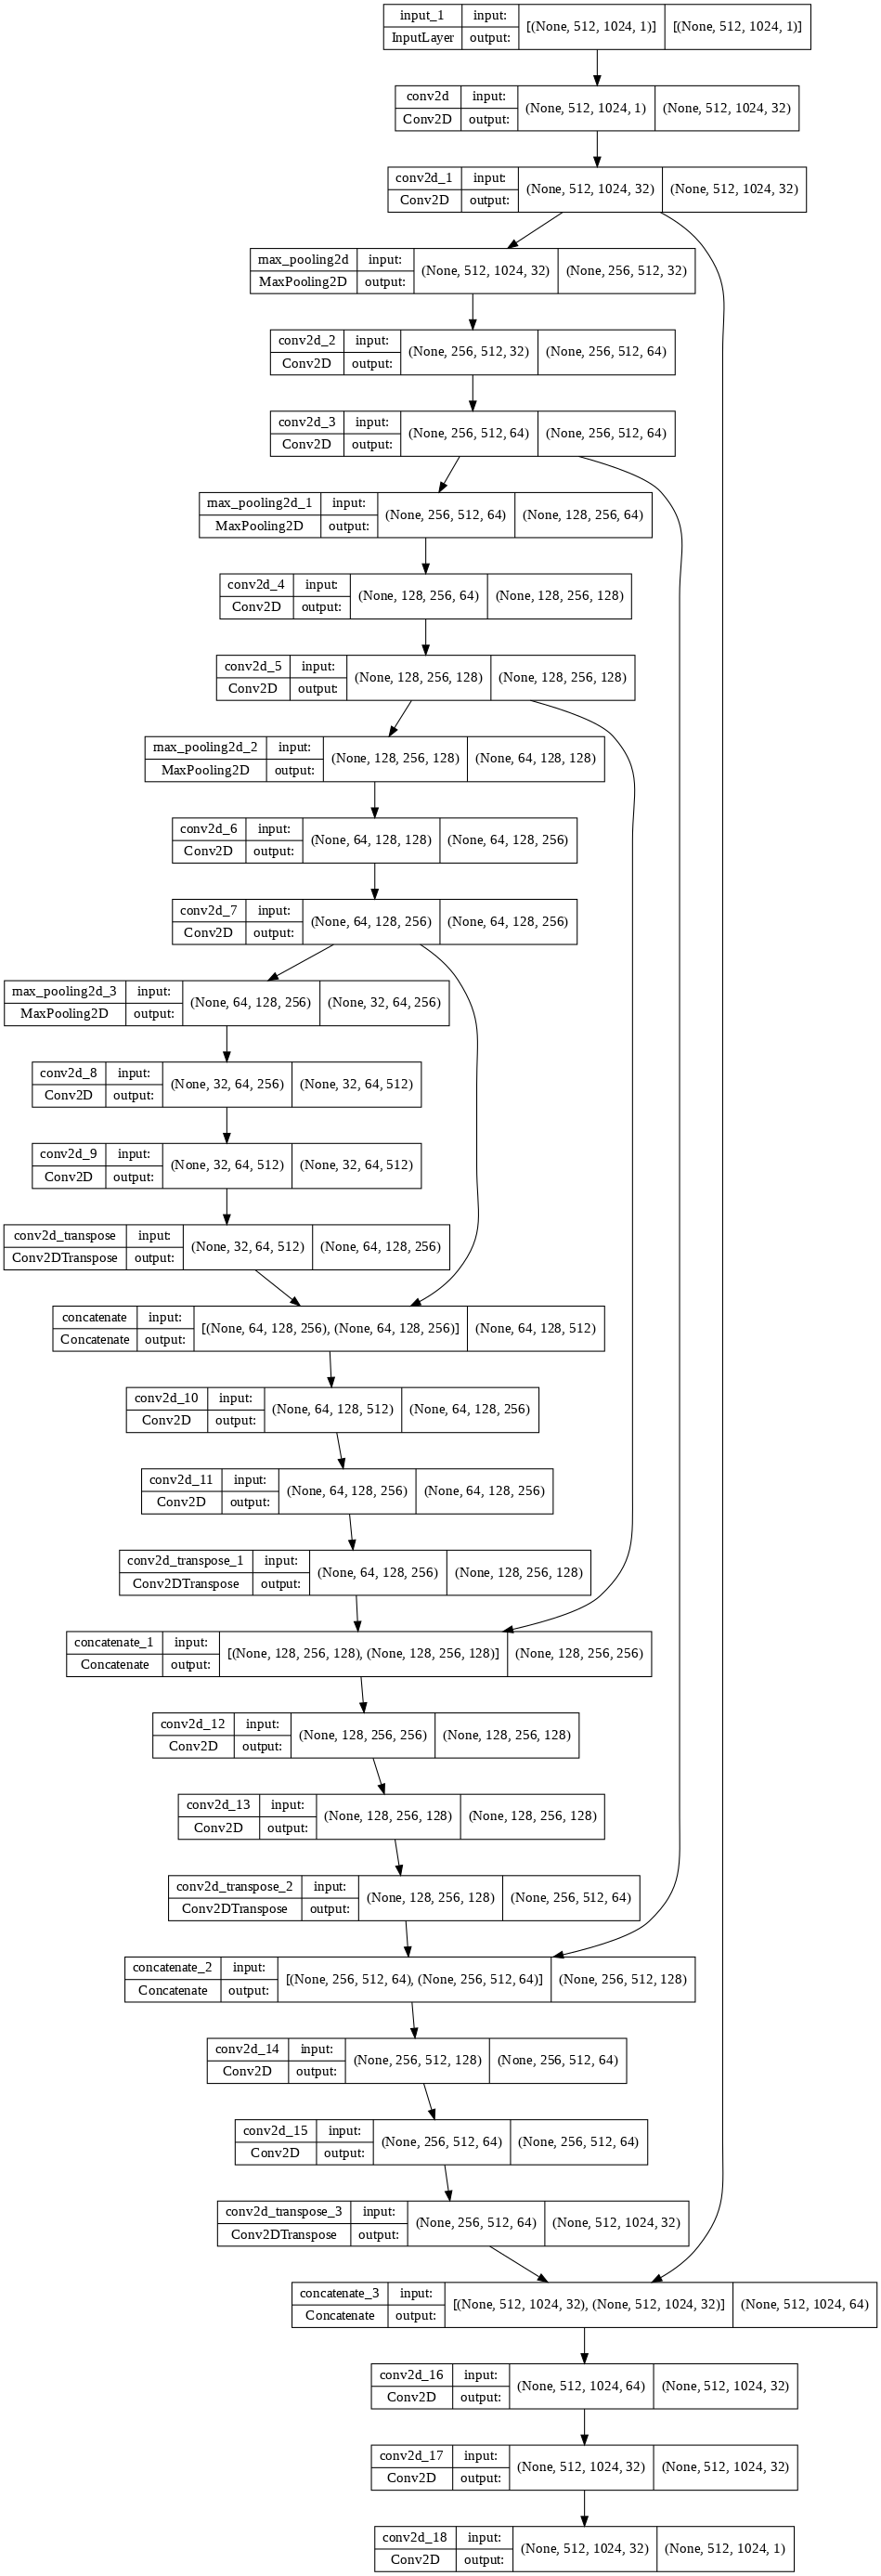

In [ ]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error')
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(683, 512, 1024)
(683, 512, 1024)
(121, 512, 1024)
(121, 512, 1024)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 1024,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 512, 1024, 3  320         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 1024, 3  9248        ['conv2d[0][0]']                 
                                2)                                                            

# Train

In [ ]:
# images_pred_log = {"unseen" : open_resize("drive/MyDrive/PTRANS/data/xrays (all data)/9 2.png"),
#                    "unseen_hard" : open_resize("drive/MyDrive/PTRANS/data/xrays (all data)/7.png"),
#                    "training_set" : x_train[0],
#                    "test_set" : x_test[0]}

# images_pred_log = {"unseen" : open_resize("drive/MyDrive/PTRANS/data/xrays (all data)/9 2.png"),
#                    "unseen_hard" : open_resize("drive/MyDrive/PTRANS/data/xrays (all data)/7.png"),
#                    "training_set" : x_train[0]}                   

# class InpaintingEvolution(tf.keras.callbacks.Callback):
#   def __init__(self):
#     super(InpaintingEvolution, self).__init__()
#     self.dirName = seed_out
#     os.makedirs(f"drive/MyDrive/PTRANS/tasks/inpaintings_DL/unet-like autoencoder/{self.dirName}")
#     for image in images_pred_log:
#       os.makedirs(f"drive/MyDrive/PTRANS/tasks/inpaintings_DL/unet-like autoencoder/{self.dirName}/{image}")




#   def on_epoch_end(self, epoch, logs):
#     if int(epoch)%10 == 0:
#       for image in images_pred_log:
#         # print(f"drive/MyDrive/PTRANS/tasks/inpaintings_DL/unet-like autoencoder/{self.dirName}/{epoch}_{image}")
#         tmp_im = images_pred_log[image]
#         tmp_inpainting = self.model.predict(tmp_im.reshape((1,)+tmp_im.shape))
#         tmp_inpainting = tmp_inpainting.reshape(tmp_inpainting.shape[1:-1])
#         cv2.imwrite(f"drive/MyDrive/PTRANS/tasks/inpaintings_DL/unet-like autoencoder/{self.dirName}/{image}/{epoch}_{image}.png", tmp_inpainting*255)

# for image in images_pred_log:
#   cv2.imwrite(f"drive/MyDrive/PTRANS/tasks/inpaintings_DL/unet-like autoencoder/{seed_out}/{image}/{image}.png", images_pred_log[image]*255)

In [ ]:
history = model.fit(x_train, y_train, 
          validation_data=(x_val, y_val), 
          epochs=150,
          batch_size=8,
          use_multiprocessing=True,
          callbacks=[keras.callbacks.ModelCheckpoint(
                     filepath=f"drive/MyDrive/PTRANS/tasks/inpaintings_DL/unet-like autoencoder/{seed_out}.keras",
                     save_best_only=True,
                     monitor="val_loss"
                     )])

Epoch 1/150
86/86 [==============================] - 150s 1s/step - loss: 0.0579 - val_loss: 0.0170
Epoch 2/150
86/86 [==============================] - 121s 1s/step - loss: 0.0174 - val_loss: 0.0136
Epoch 3/150
86/86 [==============================] - 124s 1s/step - loss: 0.0111 - val_loss: 0.0061
Epoch 4/150
86/86 [==============================] - 127s 1s/step - loss: 0.0100 - val_loss: 0.0212
Epoch 5/150
86/86 [==============================] - 123s 1s/step - loss: 0.0115 - val_loss: 0.0105
Epoch 6/150
86/86 [==============================] - 124s 1s/step - loss: 0.0056 - val_loss: 0.0058
Epoch 7/150
86/86 [==============================] - 123s 1s/step - loss: 0.0055 - val_loss: 0.0062
Epoch 8/150
86/86 [==============================] - 124s 1s/step - loss: 0.0070 - val_loss: 0.0044
Epoch 9/150
86/86 [==============================] - 123s 1s/step - loss: 0.0046 - val_loss: 0.0060
Epoch 10/150
86/86 [==============================] - 123s 1s/step - loss: 0.0053 - val_loss: 0.0167

# Testing on images

In [ ]:
print(history.history['val_loss'].index(min(history.history['val_loss'])))
print(history.history['loss'].index(min(history.history['loss'])))

126
120


IndexError: ignored

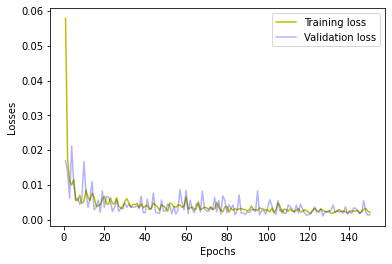

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, "y", label="Training loss", alpha=1)
plt.plot(epochs, val_loss, "b", label="Validation loss", alpha=0.3)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

(512, 1024)


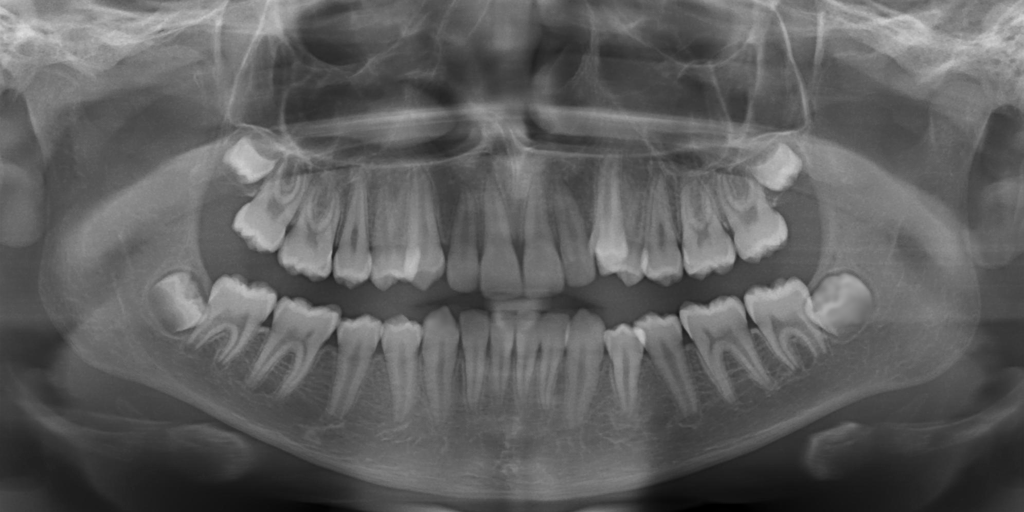

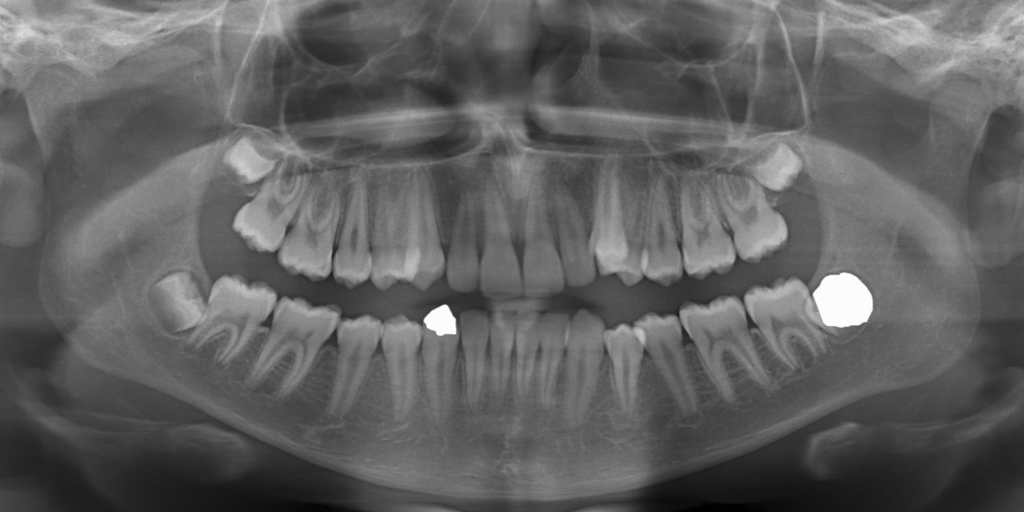

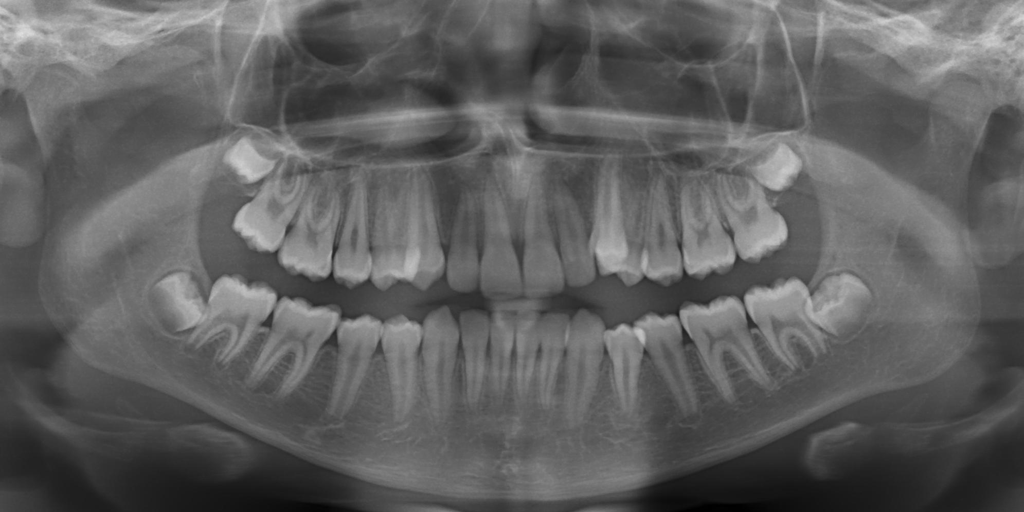

In [ ]:
im = x_train[3].copy()
print(im.shape)
impainted_image = model.predict(im.reshape((1,)+im.shape))
show_full_res(impainted_image.reshape(impainted_image.shape[1:-1]))
show_full_res(x_train[3])
show_full_res(y_train[3])

In [ ]:
im = x_test[8].copy()
impainted_image = model.predict(im.reshape((1,)+im.shape))
show(impainted_image.reshape(impainted_image.shape[1:-1]))
show(x_test[8])
show(y_test[8])

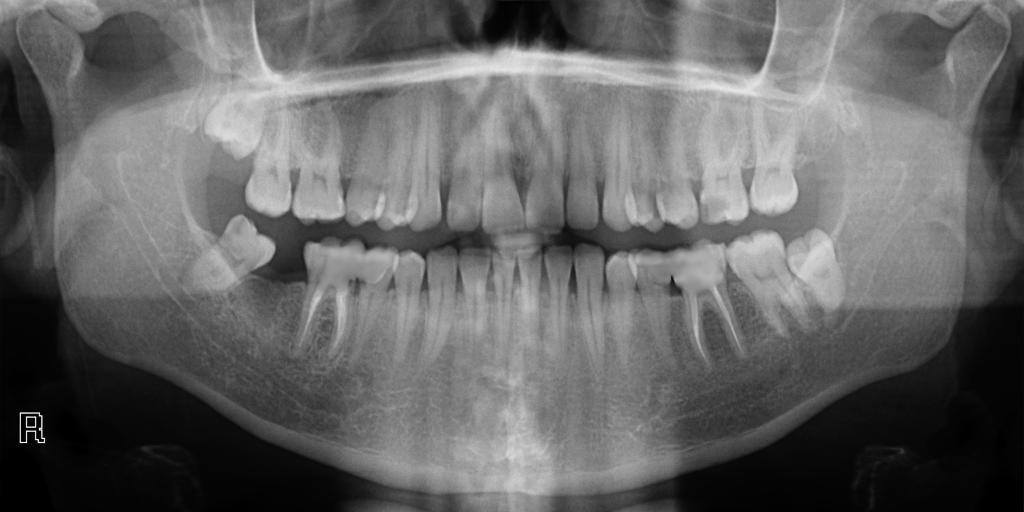

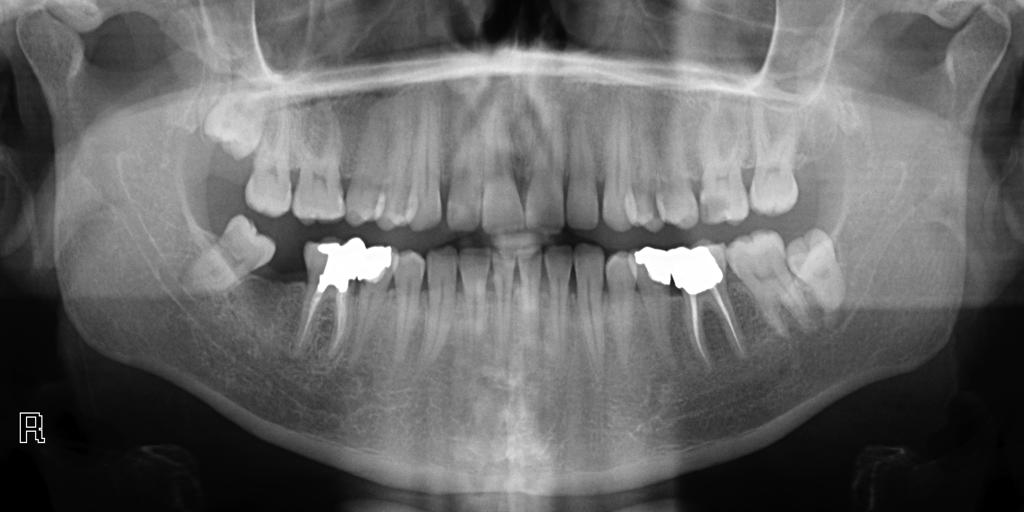

In [ ]:
im = open_resize("drive/MyDrive/PTRANS/data/xrays (all data)/9 2.png")
impainted_image = model.predict(im.reshape((1,)+im.shape))
show_full_res(impainted_image.reshape(impainted_image.shape[1:-1]))
show_full_res(im)


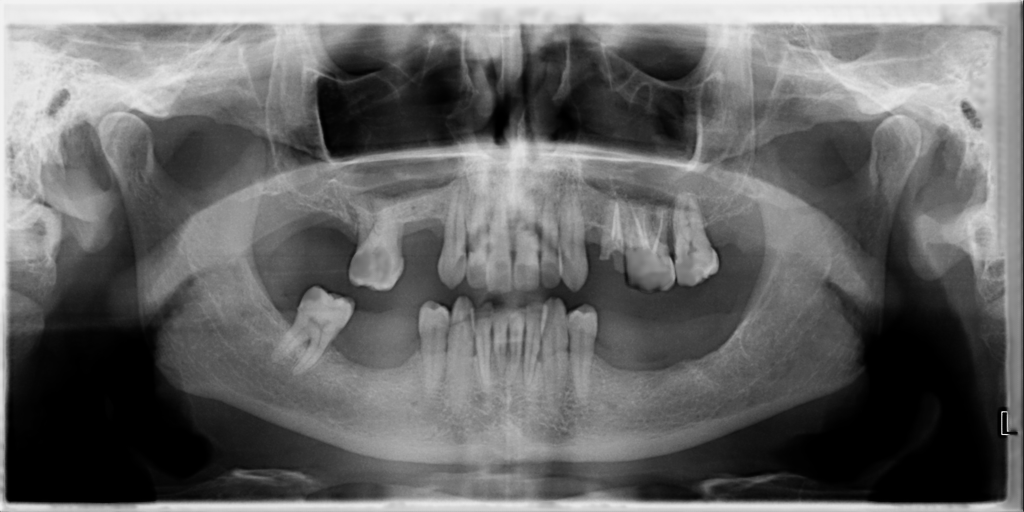

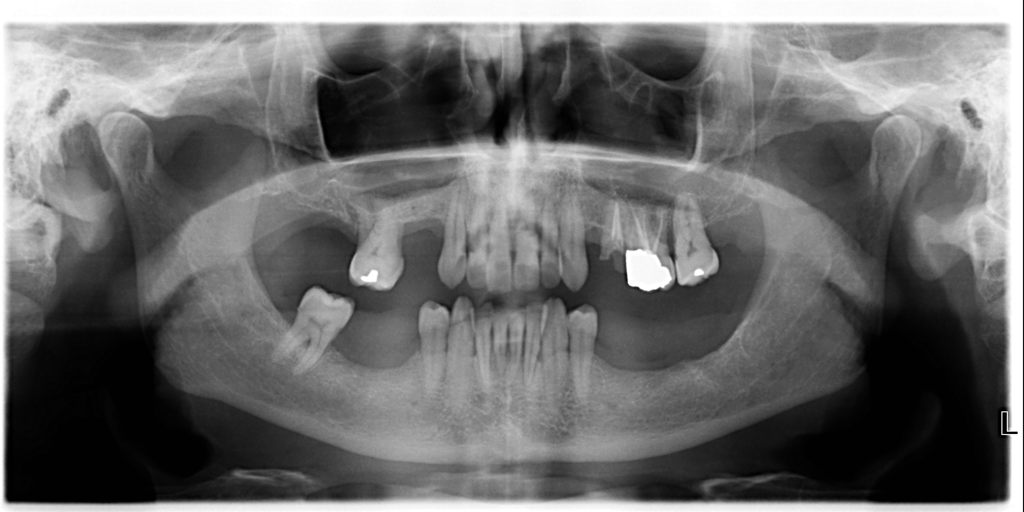

In [ ]:
im = open_resize("drive/MyDrive/PTRANS/data/xrays (all data)/V-M P-19640317-X-20181010-142144-XK8UKP70EX-4.JPG")
impainted_image = model.predict(im.reshape((1,)+im.shape))
show_full_res(impainted_image.reshape(impainted_image.shape[1:-1]))
show_full_res(im)

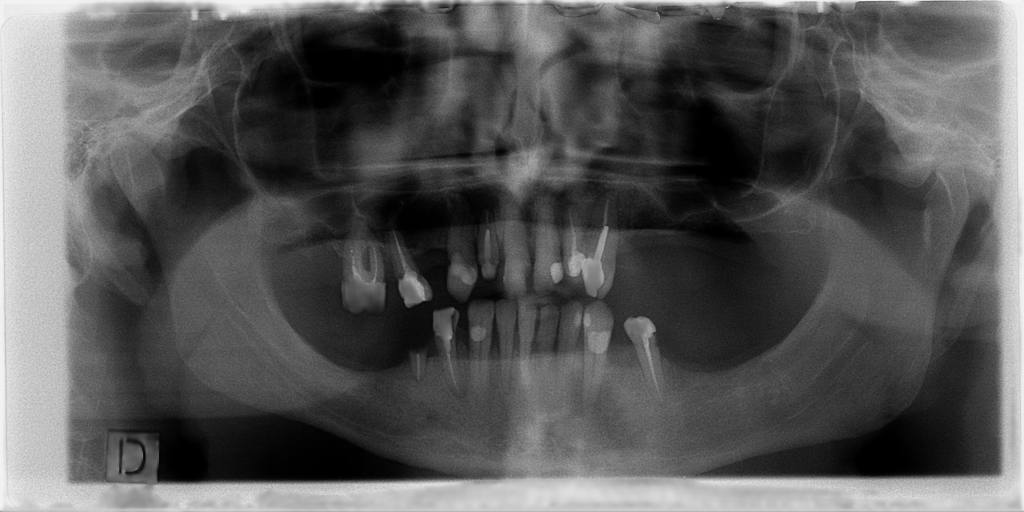

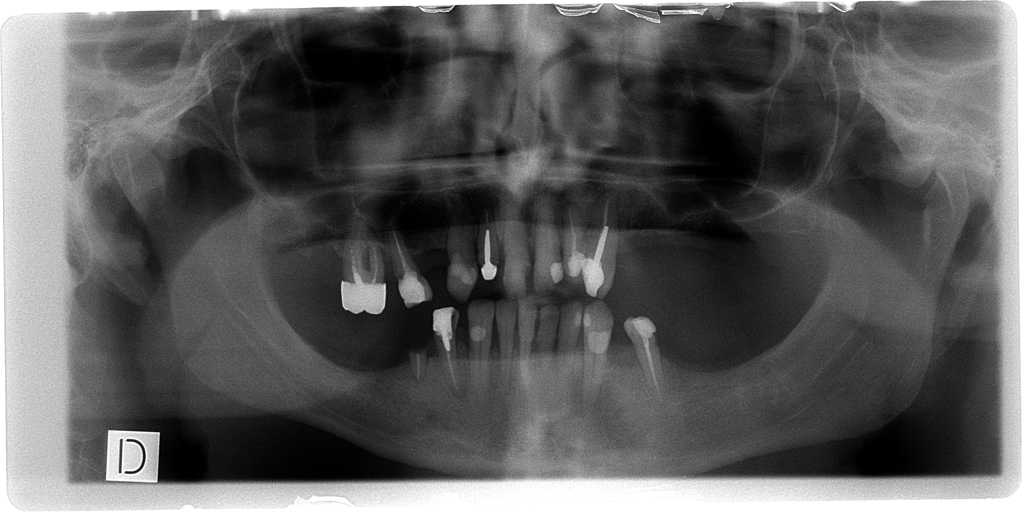

In [ ]:
im = open_resize("drive/MyDrive/PTRANS/data/xrays (all data)/22-X-20110204-171155-XU3SQD02C7E+-4.JPG")
impainted_image = model.predict(im.reshape((1,)+im.shape))
show_full_res(impainted_image.reshape(impainted_image.shape[1:-1]))
show_full_res(im)